# US Adult Income

## Purpose of the project

<div style="background-color: rgba(255, 255, 0, 0.15); padding: 8px;">
...
</div>

## Imports

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.model_selection import KFold, GridSearchCV, cross_val_score
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report, confusion_matrix)
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from imblearn.under_sampling import RandomUnderSampler

import joblib

from fairlearn.metrics import demographic_parity_difference, equalized_odds_difference

from folktables import generate_categories

ModuleNotFoundError: No module named 'folktables'

## Table of Contents

- [1. Dataset](#dataset) 
    - [a. Description](#description) 
    - [b. Data cleaning](#data-cleaning) 

## Dataset

### Description

<div style="background-color: rgba(255, 255, 0, 0.15); padding: 8px;">

The US Adult Income dataset, sourced from [Kaggle](https://www.kaggle.com/datasets/johnolafenwa/us-census-data), was originally extracted by Barry Becker from the 1994 US Census Database. It contains anonymous data about various social and economic factors, including occupation, age, native country, race, capital gain, capital loss, education, work class, and more.

Each entry in the dataset is labeled based on income, categorizing individuals as earning either ">50K" or "<=50K" annually. This classification allows for the analysis of how different social factors correlate with income levels.

The dataset is divided into two CSV files:
* `adult-training.txt`: Contains data used for training models.
* `adult-test.txt`: Contains data used for testing models.

This dataset is commonly utilized for machine learning tasks focused on income prediction and social factor analysis.
</div>

### Data cleaning

##### Read data

In [1]:
# Define path to data files
train_file = "data/adult-training.csv"
test_file = "data/adult-test.csv"

In [2]:
# Define columns
COLUMNS = ["age", "workclass", "fnlwgt", "education","education_num",
           "marital_status", "occupation", "relationship", "race", "gender",
           "capital_gain", "capital_loss", "hours_per_week", "native_country", "income_bracket"]

In [5]:
# Read data into df
df_train = pd.read_csv(train_file, names = COLUMNS, skipinitialspace = True, engine= "python")
df_test = pd.read_csv(test_file, names = COLUMNS, skipinitialspace = True, skiprows=1, engine = "python")

##### Investigate the data

In [6]:
# Set size
print("Train set :", df_train.shape)
print("Test set :", df_test.shape)

Train set : (32561, 15)
Test set : (16281, 15)


In [7]:
# Check if there are any missing (NaN) values in the DataFrame
print("Any missing (NaN) values in the train set ? :", df_train.isnull().values.any())
print("Any missing (NaN) values in the test set ? :", df_test.isnull().values.any())

Any missing (NaN) values in the train set ? : False
Any missing (NaN) values in the test set ? : False


<div style="background-color: rgba(255, 255, 0, 0.15); padding: 8px;">
&rarr; We don't need to remove NaN values
</div>

In [8]:
# Display the first few rows of the training data to verify
df_train.head()

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,gender,capital_gain,capital_loss,hours_per_week,native_country,income_bracket
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


<div style="background-color: rgba(255, 255, 0, 0.15); padding: 8px;">
Distribution of income values :
</div>

In [9]:
#  in train set
df_train.income_bracket.value_counts(normalize=True)

income_bracket
<=50K    0.75919
>50K     0.24081
Name: proportion, dtype: float64

In [10]:
# Distribution of income values in test set
df_test.income_bracket.value_counts(normalize=True)

income_bracket
<=50K.    0.763774
>50K.     0.236226
Name: proportion, dtype: float64

<div style="background-color: rgba(255, 255, 0, 0.15); padding: 8px;">
Statistics on train set :
</div>

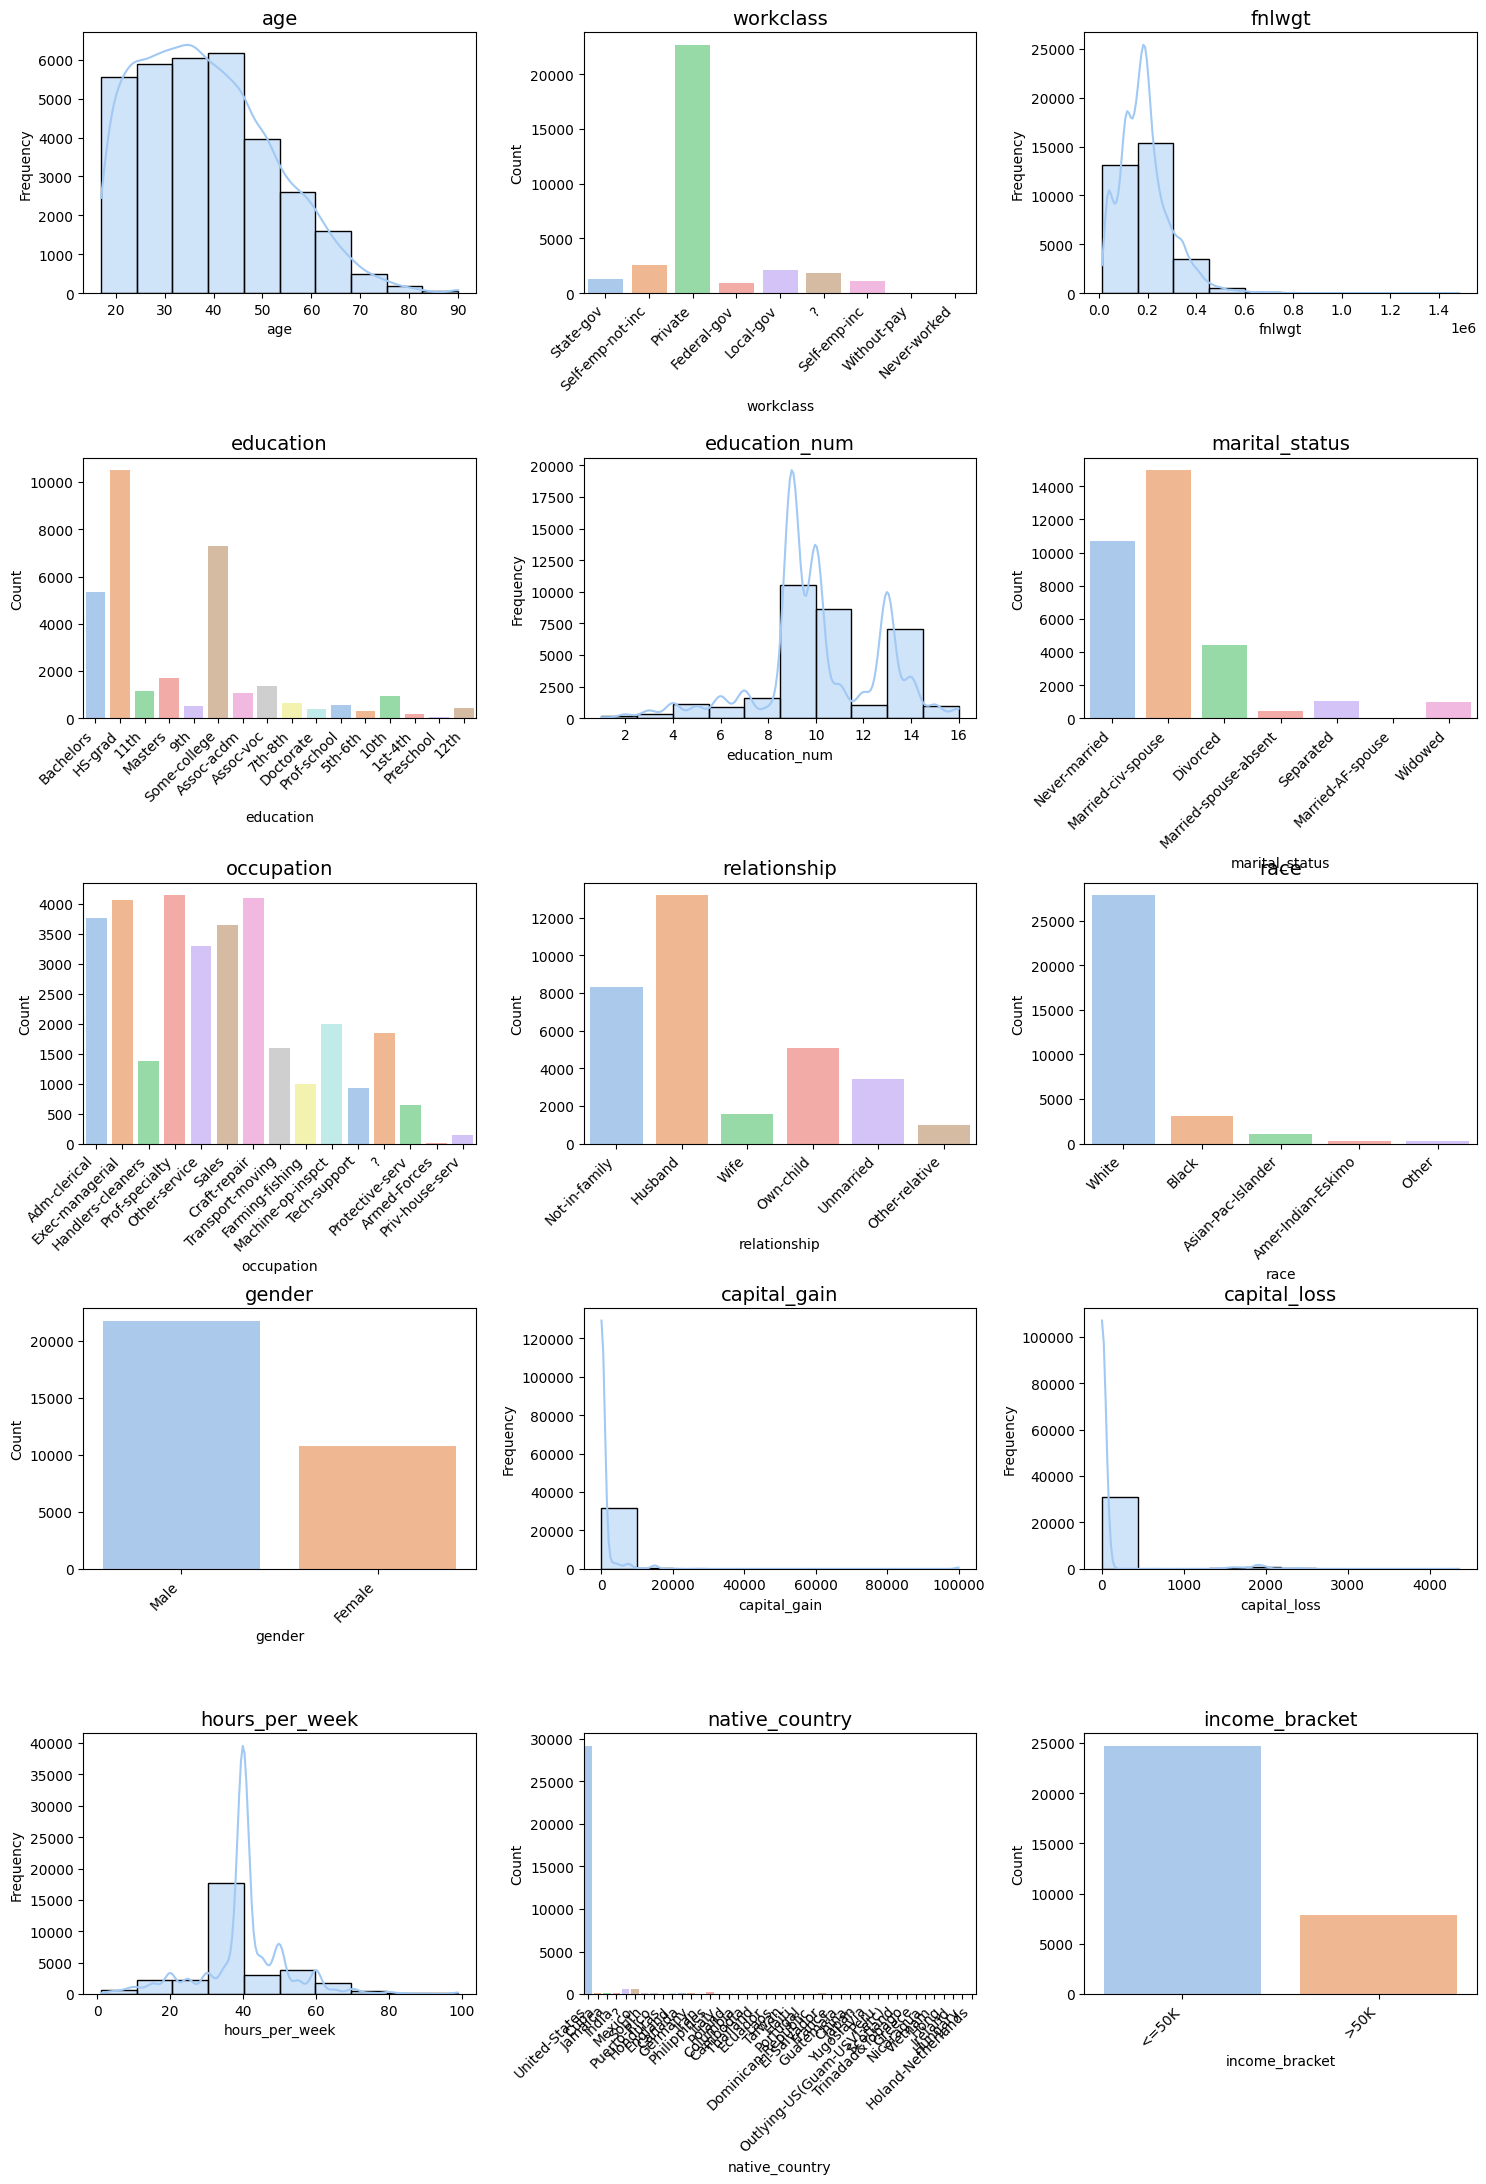

In [11]:
num_cols = 3
num_plots = len(df_train.columns)
num_rows = (num_plots + num_cols - 1) // num_cols

fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows))
axes = axes.flatten()

for i, column in enumerate(df_train.columns):
    ax = axes[i]
    
    # Vérification du type de données
    if isinstance(df_train[column].dtype, pd.CategoricalDtype) or df_train[column].dtype == object:
        sns.countplot(x=column, hue=column, data=df_train, ax=ax, palette="pastel", legend=False)
        ax.set_ylabel("Count")
    
        ax.set_xticks(range(len(df_train[column].unique())))
        ax.set_xticklabels(df_train[column].unique(), rotation=45, ha='right')

    else:
        # Palette dynamique selon le nombre d'éléments uniques
        unique_vals = df_train[column].nunique()
        color = sns.color_palette("pastel", n_colors=unique_vals)
        
        sns.histplot(df_train[column], kde=True, bins=10, ax=ax, color=color[0])
        ax.set_ylabel("Frequency")
    
    ax.set_title(f"{column}", fontsize=14)

# Supprimer les sous-graphiques inutilisés
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.subplots_adjust(bottom=0.2)
plt.show()


##### Clean data

In [12]:
# Set label column
df_train['income_bracket'] = (df_train["income_bracket"].apply(lambda x: ">50K" in x)).astype(int)
df_test['income_bracket'] = (df_test["income_bracket"].apply(lambda x: ">50K" in x)).astype(int)

In [13]:
df_train.head()

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,gender,capital_gain,capital_loss,hours_per_week,native_country,income_bracket
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,0
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,0
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,0
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,0
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,0


In [13]:
# [c for c in dtrain.columns if c not in df_test.columns]

## MLP

In [17]:
# Convert categorical variables into dummy/indicator variables using one-hot encoding.
train_encoded = pd.get_dummies(df_train)
train_encoded.head()

,age,fnlwgt,education_num,capital_gain,capital_loss,hours_per_week,income_bracket,workclass_?,workclass_Federal-gov,workclass_Local-gov,...,native_country_Portugal,native_country_Puerto-Rico,native_country_Scotland,native_country_South,native_country_Taiwan,native_country_Thailand,native_country_Trinadad&Tobago,native_country_United-States,native_country_Vietnam,native_country_Yugoslavia
0,39,77516,13,2174,0,40,0,False,False,False,...,False,False,False,False,False,False,False,True,False,False
1,50,83311,13,0,0,13,0,False,False,False,...,False,False,False,False,False,False,False,True,False,False
2,38,215646,9,0,0,40,0,False,False,False,...,False,False,False,False,False,False,False,True,False,False
3,53,234721,7,0,0,40,0,False,False,False,...,False,False,False,False,False,False,False,True,False,False
4,28,338409,13,0,0,40,0,False,False,False,...,False,False,False,False,False,False,False,False,False,False


### Training 

In [18]:
cv = KFold(n_splits=5, shuffle=True, random_state=5)

In [20]:
x = train_encoded.copy()
x.drop('income_bracket', axis=1, inplace=True)
y = train_encoded['income_bracket']

# Normalization
scaler = MinMaxScaler()
x[x.columns] = scaler.fit_transform(x[x.columns])
x.head()

,age,fnlwgt,education_num,capital_gain,capital_loss,hours_per_week,workclass_?,workclass_Federal-gov,workclass_Local-gov,workclass_Never-worked,...,native_country_Portugal,native_country_Puerto-Rico,native_country_Scotland,native_country_South,native_country_Taiwan,native_country_Thailand,native_country_Trinadad&Tobago,native_country_United-States,native_country_Vietnam,native_country_Yugoslavia
0,0.301370,0.044302,0.800000,0.02174,0.0,0.397959,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.452055,0.048238,0.800000,0.00000,0.0,0.122449,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.287671,0.138113,0.533333,0.00000,0.0,0.397959,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.493151,0.151068,0.400000,0.00000,0.0,0.397959,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.150685,0.221488,0.800000,0.00000,0.0,0.397959,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
mlp = MLPClassifier(random_state=5, max_iter=200)
param_grid = {'hidden_layer_sizes': [(50,50,50), (50,100,50), (100,)],
              'activation': ['tanh', 'relu'],
              'solver': ['sgd', 'adam'],
              'alpha': [0.0001, 0.05],
              'learning_rate': ['constant','adaptive']}
grid1 = GridSearchCV(mlp, param_grid, cv=cv).fit(x, y)
print("Grid MLP: ", grid1.best_score_, grid1.best_params_)

In [44]:
print("Grid MLP: ", grid1.best_score_, grid1.best_params_)

Grid MLP:  0.8549184799933303 {'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50, 50, 50), 'learning_rate': 'constant', 'solver': 'adam'}


### Evaluation

In [ ]:
clf = grid1.best_estimator_
Model = ["MLP Classifier"]
Accuracy = [cross_val_score(clf, x, y, cv=cv, scoring='accuracy').mean()]
Precision = [cross_val_score(clf, x, y, cv=cv, scoring='precision').mean()]
Recall = [cross_val_score(clf, x, y, cv=cv, scoring='recall').mean()]
F1 = [cross_val_score(clf, x, y, cv=cv, scoring='f1').mean()]
AUC = [cross_val_score(clf, x, y, cv=cv, scoring='roc_auc').mean()]

In [26]:
evaluation = pd.DataFrame({'Model': Model, 
                           'Accuracy': Accuracy, 
                           'Precision': Precision, 
                           'Recall': Recall,
                           'F1 Score': F1, 
                           'AUC': AUC})
print("FOLLOWING ARE THE TRAINING SCORES: ")
evaluation

FOLLOWING ARE THE TRAINING SCORES: 


,Model,Accuracy,Precision,Recall,F1 Score,AUC
0,MLP Classifier,0.854918,0.731076,0.629414,0.676108,0.909671


In [46]:
# Save the model
joblib.dump(grid1.best_estimator_, 'mlp_model.pkl')

['mlp_model.pkl']

In [ ]:
# To load the model
mlp_loaded = joblib.load('mlp_model.pkl')

# Bias

##### Sensitive features

<div style="background-color: rgba(255, 255, 0, 0.15); padding: 8px;">

We consider the following sensitive features:

* `race`- Risk of racial discrimination in economic decisions.
* `gender` - Pay differentials and gender stereotypes can introduce bias.
* `native_country` - Can be a proxy for socio-economic disparities based on origin.
* `age` - Can lead to discrimination linked to professional seniority or access to economic opportunities.
* `marital_status` - May be correlated with income inequalities based on societal norms.

Among them, gender is binary, age is continuous (requires binning) and the others are categorical


</div>

##### Detailed sensitive groups

<div style="background-color: rgba(255, 255, 0, 0.15); padding: 8px;">

**Gender**
* Male
* Female

**Age**
* Less than 30 years
* Between 30 and 40
* Between 40 and 50
* Greater than 50

**Race**
* White
* Black
* Asian-Pac-Islander
* Amer-Indian-Eskimo
* Other

**Marital Statut**
* Married
* Widowed
* Divorced
* Separated
* Never married
* Married-civ-spouse
* Married-AF-spouse

</div>

In [14]:
sensitive_features = ['race', 'gender', 'native_country', 'age', 'marital_status']

### Preparing the train set

In [15]:
# Split the DataFrame into features (x_train) and target variable (y_train)
x_train = df_train.copy()
x_train.drop('income_bracket', axis=1, inplace=True)
y_train = df_train['income_bracket']

In [16]:
# Binning the age feature into groups
x_train['Age_less_than_30'] = x_train['age'] < 30
x_train['Age_between_30_and_40'] = (x_train['age'] >= 30) & (x_train['age'] < 40)
x_train['Age_between_40_and_50'] = (x_train['age'] >= 40) & (x_train['age'] < 50)
x_train['Age_greater_than_50'] = x_train['age'] >= 50

# Dropping the original 'age' column after binning
x_train.drop('age', axis=1, inplace=True)

In [17]:
x_train.head()

,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,gender,capital_gain,capital_loss,hours_per_week,native_country,Age_less_than_30,Age_between_30_and_40,Age_between_40_and_50,Age_greater_than_50
0,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,False,True,False,False
1,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,False,False,False,True
2,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,False,True,False,False
3,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,False,False,False,True
4,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,True,False,False,False


In [18]:
# Convert categorical variables into dummy/indicator variables using one-hot encoding.
x_train_encoded = pd.get_dummies(x_train)

In [19]:
x_train_encoded.head()

,fnlwgt,education_num,capital_gain,capital_loss,hours_per_week,Age_less_than_30,Age_between_30_and_40,Age_between_40_and_50,Age_greater_than_50,workclass_?,...,native_country_Portugal,native_country_Puerto-Rico,native_country_Scotland,native_country_South,native_country_Taiwan,native_country_Thailand,native_country_Trinadad&Tobago,native_country_United-States,native_country_Vietnam,native_country_Yugoslavia
0,77516,13,2174,0,40,False,True,False,False,False,...,False,False,False,False,False,False,False,True,False,False
1,83311,13,0,0,13,False,False,False,True,False,...,False,False,False,False,False,False,False,True,False,False
2,215646,9,0,0,40,False,True,False,False,False,...,False,False,False,False,False,False,False,True,False,False
3,234721,7,0,0,40,False,False,False,True,False,...,False,False,False,False,False,False,False,True,False,False
4,338409,13,0,0,40,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [20]:
# Check if no columns are missing.
[c for c in x_train_encoded.columns if c not in pd.get_dummies(df_train).columns]

['Age_less_than_30',
 'Age_between_30_and_40',
 'Age_between_40_and_50',
 'Age_greater_than_50']

In [21]:
# Scaling dataset
scaler = MinMaxScaler()
x_train_scaled = x_train_encoded.copy()
x_train_scaled[x_train_scaled.columns] = scaler.fit_transform(x_train_scaled[x_train_scaled.columns])
x_train_scaled.head()

,fnlwgt,education_num,capital_gain,capital_loss,hours_per_week,Age_less_than_30,Age_between_30_and_40,Age_between_40_and_50,Age_greater_than_50,workclass_?,...,native_country_Portugal,native_country_Puerto-Rico,native_country_Scotland,native_country_South,native_country_Taiwan,native_country_Thailand,native_country_Trinadad&Tobago,native_country_United-States,native_country_Vietnam,native_country_Yugoslavia
0,0.044302,0.800000,0.02174,0.0,0.397959,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.048238,0.800000,0.00000,0.0,0.122449,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.138113,0.533333,0.00000,0.0,0.397959,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.151068,0.400000,0.00000,0.0,0.397959,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.221488,0.800000,0.00000,0.0,0.397959,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Training

In [22]:
sampler = RandomUnderSampler()
subxtrain, subytrain = sampler.fit_resample(x_train_scaled, y_train)
subxtrain

,fnlwgt,education_num,capital_gain,capital_loss,hours_per_week,Age_less_than_30,Age_between_30_and_40,Age_between_40_and_50,Age_greater_than_50,workclass_?,...,native_country_Portugal,native_country_Puerto-Rico,native_country_Scotland,native_country_South,native_country_Taiwan,native_country_Thailand,native_country_Trinadad&Tobago,native_country_United-States,native_country_Vietnam,native_country_Yugoslavia
2395,0.197077,0.466667,0.000000,0.399679,0.397959,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
31963,0.094962,0.533333,0.000000,0.000000,0.479592,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
14592,0.143548,0.400000,0.000000,0.000000,0.193878,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11049,0.251070,0.800000,0.000000,0.000000,0.397959,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
30707,0.091255,0.533333,0.000000,0.000000,0.142857,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32539,0.186826,1.000000,0.000000,0.000000,0.091837,0.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
32545,0.067382,0.733333,0.000000,0.000000,0.193878,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
32554,0.210253,0.866667,0.000000,0.000000,0.397959,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
32557,0.096500,0.533333,0.000000,0.000000,0.397959,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [23]:
subytrain.value_counts()

income_bracket
0    7841
1    7841
Name: count, dtype: int64

In [24]:
# Define the MLP model
mlp = MLPClassifier(hidden_layer_sizes=(100, 100, 100),  # 3 hidden layers with 100 neurons each
                    activation='tanh', 
                    solver='adam', 
                    alpha=0.005, 
                    learning_rate='constant', 
                    random_state=5, 
                    max_iter=500)  # Number of training iterations

# Train the model
mlp.fit(x_train_scaled, y_train)

# Evaluate the model
print("MLP Training Accuracy:", mlp.score(x_train_scaled, y_train))

MLP Training Accuracy: 0.9485580909677221


### Preparing the test set

In [25]:
# Split the DataFrame into features (x_test) and target variable (y_test)
x_test = df_test.copy()
x_test.drop('income_bracket', axis=1, inplace=True)
y_test = df_test['income_bracket']

In [26]:
# Binning the age feature into groups
x_test['Age_less_than_30'] = x_test['age'] < 30
x_test['Age_between_30_and_40'] = (x_test['age'] >= 30) & (x_test['age'] < 40)
x_test['Age_between_40_and_50'] = (x_test['age'] >= 40) & (x_test['age'] < 50)
x_test['Age_greater_than_50'] = x_test['age'] >= 50

# Dropping the original 'age' column after binning
x_test.drop('age', axis=1, inplace=True)

In [27]:
x_test.head()

,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,gender,capital_gain,capital_loss,hours_per_week,native_country,Age_less_than_30,Age_between_30_and_40,Age_between_40_and_50,Age_greater_than_50
0,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,True,False,False,False
1,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,False,True,False,False
2,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,True,False,False,False
3,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,False,False,True,False
4,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,True,False,False,False


In [28]:
# Convert categorical variables into dummy/indicator variables using one-hot encoding.
x_test_encoded = pd.get_dummies(x_test)

# Ensure test set has the same columns as the train set
x_test_encoded = x_test_encoded.reindex(columns=x_train_encoded.columns, fill_value=0)

In [29]:
x_test_encoded.head()

,fnlwgt,education_num,capital_gain,capital_loss,hours_per_week,Age_less_than_30,Age_between_30_and_40,Age_between_40_and_50,Age_greater_than_50,workclass_?,...,native_country_Portugal,native_country_Puerto-Rico,native_country_Scotland,native_country_South,native_country_Taiwan,native_country_Thailand,native_country_Trinadad&Tobago,native_country_United-States,native_country_Vietnam,native_country_Yugoslavia
0,226802,7,0,0,40,True,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
1,89814,9,0,0,50,False,True,False,False,False,...,False,False,False,False,False,False,False,True,False,False
2,336951,12,0,0,40,True,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
3,160323,10,7688,0,40,False,False,True,False,False,...,False,False,False,False,False,False,False,True,False,False
4,103497,10,0,0,30,True,False,False,False,True,...,False,False,False,False,False,False,False,True,False,False


In [30]:
# Check if no columns are missing.
[c for c in x_test_encoded.columns if c not in pd.get_dummies(df_test).columns]

['Age_less_than_30',
 'Age_between_30_and_40',
 'Age_between_40_and_50',
 'Age_greater_than_50',
 'native_country_Holand-Netherlands']

In [31]:
# Scaling dataset
scaler = MinMaxScaler()
x_test_scaled = x_test_encoded.copy()
x_test_scaled[x_test_scaled.columns] = scaler.fit_transform(x_test_scaled[x_test_scaled.columns])
x_test_scaled.head()

,fnlwgt,education_num,capital_gain,capital_loss,hours_per_week,Age_less_than_30,Age_between_30_and_40,Age_between_40_and_50,Age_greater_than_50,workclass_?,...,native_country_Portugal,native_country_Puerto-Rico,native_country_Scotland,native_country_South,native_country_Taiwan,native_country_Thailand,native_country_Trinadad&Tobago,native_country_United-States,native_country_Vietnam,native_country_Yugoslavia
0,0.144430,0.400000,0.000000,0.0,0.397959,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.051677,0.533333,0.000000,0.0,0.500000,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.219011,0.733333,0.000000,0.0,0.397959,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.099418,0.600000,0.076881,0.0,0.397959,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.060942,0.600000,0.000000,0.0,0.295918,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


### Classification Performance

In [32]:
yhat = mlp.predict(x_test_encoded)
print(classification_report(np.array(y_test), yhat, target_names=['<=50K', '>50K']))

              precision    recall  f1-score   support

       <=50K       0.81      0.93      0.87     12435
        >50K       0.57      0.31      0.40      3846

    accuracy                           0.78     16281
   macro avg       0.69      0.62      0.63     16281
weighted avg       0.76      0.78      0.76     16281



### Suite 

In [34]:
import feature_engine
print(feature_engine.__version__)


1.8.3


In [49]:
from justicia.metrics import Metric


model_name = "mlp"

justicia_results = []
for sensitive_feature_set in [['gender'], ['gender', 'race']]:

    metric = Metric(model=mlp,
                    data=x_test_scaled,
                    sensitive_attributes=sensitive_feature_set,
                    verbose=False,
                    discretization_bins=10,
                    encoding="best-correlated",
                    dag_threshold=0.6,
                    dag_filename=f"dag_{model_name}_" + "_".join(sensitive_feature_set) +".pkl" # cached dag location
          )
    metric.compute()
    justicia_results.append(metric)


Hi there!  pysat will nominally store data in a 'pysatData' directory which needs to be assigned. Please run `pysat.params['data_dirs'] = path` where path specifies one or more existing top-level directories that may be used to store science data. `path` may either be a single string or a list of strings.


ModuleNotFoundError: No module named 'pysat.pb'

In [ ]:
# Importation des bibliothèques nécessaires
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report



# Fonction pour calculer les taux de prédiction positive par groupe sensible
def compute_positive_prediction_rates(feature_name, df, y_true, y_pred):
    groups = df[feature_name].unique()
    rates = {}
    for group in groups:
        mask = df[feature_name] == group
        if mask.sum() > 0:
            rates[group] = y_pred[mask].mean()  # Proportion de >50K dans chaque groupe
    return rates

# Création des graphiques pour chaque feature sensible
fig, axes = plt.subplots(len(sensitive_features), 1, figsize=(8, 5 * len(sensitive_features)))

for i, feature in enumerate(sensitive_features):
    rates = compute_positive_prediction_rates(feature, df_test, y_test, yhat)
    sorted_rates = dict(sorted(rates.items(), key=lambda item: item[1]))  # Tri par ordre croissant

    ax = axes[i]
    bars = ax.barh(list(sorted_rates.keys()), list(sorted_rates.values()), color='skyblue')
    ax.bar_label(bars, fmt='%.2f')
    ax.set_title(f"Taux de prédiction positive (>50K) par groupe - {feature}", fontsize=14)
    ax.set_xlabel("P(ŷ = 1 | groupe)", fontsize=12)
    ax.set_xlim(0, 1)

plt.tight_layout()
plt.show()


# En plus  :

In [52]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
import seaborn as sns

rfclf = RandomForestClassifier()

rfclf.fit(x_train_scaled, y_train)

y_hat_rfclf = rfclf.predict(x_test_scaled)
mat = confusion_matrix(y_test,y_hat_rfclf)
print(mat)



[[11354  1081]
 [ 1574  2272]]


In [53]:
shap
import shap
explainer = shap.Explainer(mlp_loaded)
shap_values = explainer.shap_values(x_scaled)

shap.summary_plot(shap_values, x_scaled)


NameError: name 'shap' is not defined